# <center> Unsupervised learning: PCA and clustering

## 1. Introduction

The main feature of unsupervised learning algorithms, when compared to classification and regression methods, is that input data are unlabeled (i.e. no labels or classes given) and that the algorithm learns the structure of the data without any assistance. This creates two main differences. First, it allows us to process large amounts of data because the data does not need to be manually labeled. Second, it is difficult to evaluate the quality of an unsupervised algorithm due to the absence of an explicit goodness metric as used in supervised learning.  

One of the most common tasks in unsupervised learning is dimensionality reduction. On one hand, dimensionality reduction may help with data visualization (e.g. t-SNA method) while, on the other hand, it may help deal with the multicollinearity of your data and prepare the data for a supervised learning method (e.g. decision trees).


## 2. Principal Component Analysis (PCA)

### Intuition, theories, and application issues

Principal Component Analysis is one of the easiest, most intuitive, and most frequently used methods for dimensionality reduction, projecting data onto its orthogonal feature subspace.


More generally speaking, all observations can be considered as an ellipsoid in a subspace of an initial feature space, and the new basis set in this subspace is aligned with the ellipsoid axes. This assumption lets us remove highly correlated features since basis set vectors are orthogonal. 
In the general case, the resulting ellipsoid dimensionality matches the initial space dimensionality, but the assumption that our data lies in a subspace with a smaller dimension allows us to cut off the "excessive" space with the new projection (subspace). We accomplish this in a 'greedy' fashion, sequentially selecting each of the ellipsoid axes by identifying where the dispersion is maximal.
 

Let's take a look at the mathematical formulation of this process:

In order to decrease the dimensionality of our data from $n$ to $k$ with $k \leq n$, we sort our list of axes in order of decreasing dispersion and take the top-$k$ of them.

We begin by computing the dispersion and the covariance of the initial features. This is usually done with the covariance matrix. According to the covariance definition, the covariance of two features is computed as follows: $$cov(X_i, X_j) = E[(X_i - \mu_i) (X_j - \mu_j)] = E[X_i X_j] - \mu_i \mu_j,$$ where $\mu_i$ is the expected value of the $i$th feature. It is worth noting that the covariance is symmetric, and the covariance of a vector with itself is equal to its dispersion.

Therefore the covariance matrix is symmetric with the dispersion of the corresponding features on the diagonal. Non-diagonal values are the covariances of the corresponding pair of features. In terms of matrices where $\mathbf{X}$ is the matrix of observations, the covariance matrix is as follows:

$$\Sigma = E[(\mathbf{X} - E[\mathbf{X}]) (\mathbf{X} - E[\mathbf{X}])^{T}]$$

Matrices, as linear operators, have eigenvalues and eigenvectors. They are very convenient because they describe parts of our space that do not rotate and only stretch when we apply linear operators on them; eigenvectors remain in the same direction but are stretched by a corresponding eigenvalue. Formally, a matrix $M$ with eigenvector $w_i$ and eigenvalue $\lambda_i$ satisfy this equation: $M w_i = \lambda_i w_i$.

The covariance matrix for a sample $\mathbf{X}$ can be written as a product of $\mathbf{X}^{T} \mathbf{X}$. According to the [Rayleigh quotient](https://en.wikipedia.org/wiki/Rayleigh_quotient), the maximum variation of our sample lies along the eigenvector of this matrix and is consistent with the maximum eigenvalue. Therefore, the principal components we aim to retain from the data are just the eigenvectors corresponding to the top-$k$ largest eigenvalues of the matrix.

We multiply the matrix of our data $X$ by these components to get the projection of our data onto the orthogonal basis of the chosen components. If the number of components was smaller than the initial space dimensionality,so obviously we will lose some information upon applying this transformation.


### Fisher's iris dataset

Let's start by uploading all of the essential modules and try out the iris example from the `scikit-learn` documentation. 

In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import datasets
from mpl_toolkits.mplot3d import Axes3D

# Seaborn and matplotlib settings
sns.set(style='white')
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Loading the iris dataset into a DataFrame
iris = datasets.load_iris()
df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
df['target'] = iris.target

# Convert target to category for easier plotting
df['target'] = df['target'].astype('category')

df.head()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


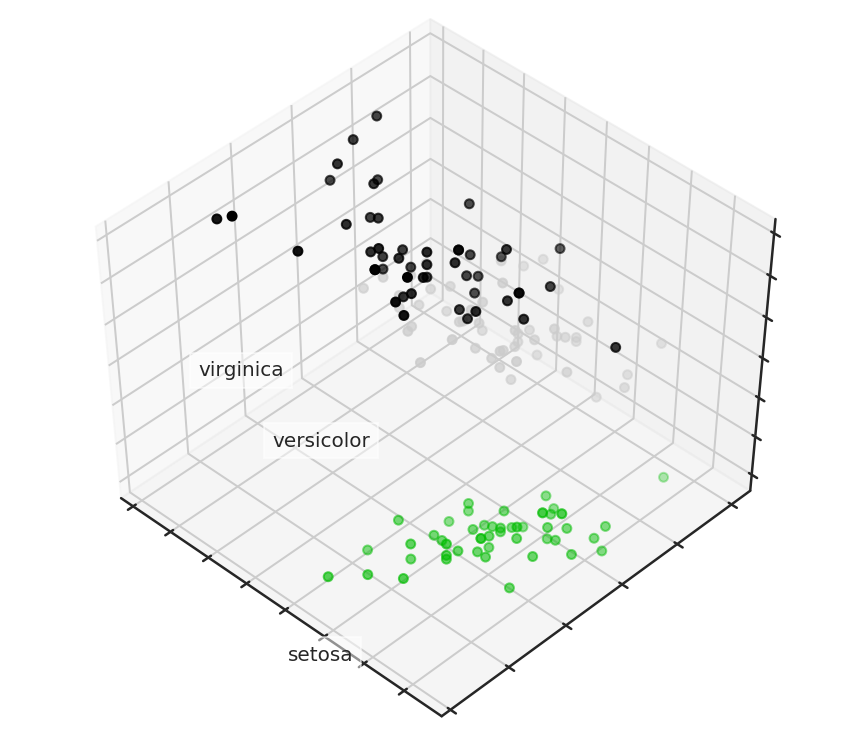

In [18]:
# Extract features (X) and target (y)
X = df.iloc[:, :-1].values
y = df['target'].cat.codes.values  # Keep numeric codes for compatibility with later code

# Plotting in 3D
fig = plt.figure(1, figsize=(6, 5))
plt.clf()
ax = Axes3D(fig, rect=[0, 0, .95, 1], elev=48, azim=134)

plt.cla()

# Add text annotations and scatter points
for name, label in zip(iris.target_names, range(len(iris.target_names))):
    ax.text3D(X[y == label, 0].mean(),
              X[y == label, 1].mean() + 1.5,
              X[y == label, 2].mean(), name,
              horizontalalignment='center',
              bbox=dict(alpha=.5, edgecolor='w', facecolor='w'))

# Change the order of labels to match the plot style
y_clr = np.choose(y, [1, 2, 0]).astype(float)
ax.scatter(X[:, 0], X[:, 1], X[:, 2], c=y_clr, cmap=plt.cm.nipy_spectral)

# Remove tick labels for better aesthetics
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])

plt.show()


The visualization in 3D is achieved by selecting only three dimensions from the four-dimensional Iris dataset. In the provided code, the following happens:

# 1. Iris Dataset Structure: The dataset contains 4 features (dimensions):

Sepal length
Sepal width
Petal length
Petal width

# 2. Dimensional Selection:

The 3D scatter plot uses only three of these four dimensions to represent the data points in a 3D space. Specifically, the X[:, 0], X[:, 1], and X[:, 2] correspond to the first three features (e.g., sepal length, sepal width, and petal length).

# 3. Data Representation:

The fourth feature is ignored for the purpose of the visualization. This is a common approach when reducing dimensionality for visualization since a 3D plot can only represent three dimensions.


Now let's see how PCA will improve the results of a simple model that is not able to correctly fit all of the training data:

# Classification by Logistic Regression

In [25]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=42)

# Logistic Regression Model
log_reg = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
log_reg.fit(X_train, y_train)

# Predictions
y_pred = log_reg.predict(X_test)

# Metrics
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.5f}')
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=iris.target_names))

# Summary Table using Statsmodels
X_train_sm = sm.add_constant(X_train)  # Add intercept for statsmodels
logit_model = sm.MNLogit(y_train, X_train_sm).fit()

# Display the summary table
summary_table = logit_model.summary2().tables[1]
import ace_tools as tools; tools.display_dataframe_to_user(name="Logistic Regression Summary Table", dataframe=summary_table)


Accuracy: 0.93333

Classification Report:
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      0.93      0.90        15
   virginica       0.93      0.87      0.90        15

    accuracy                           0.93        45
   macro avg       0.93      0.93      0.93        45
weighted avg       0.93      0.93      0.93        45

Optimization terminated successfully.
         Current function value: nan
         Iterations 21


/opt/conda/lib/python3.6/site-packages/statsmodels/discrete/discrete_model.py:2196: RuntimeWarning: invalid value encountered in true_divide
  return eXB/eXB.sum(1)[:,None]
/opt/conda/lib/python3.6/site-packages/statsmodels/base/optimizer.py:299: RuntimeWarning: invalid value encountered in greater
  oldparams) > tol)):
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
/opt/conda/lib/python3.6/site-packages/scipy/stats/_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


ModuleNotFoundError: No module named 'ace_tools'

Let's try this again, but, this time, let's reduce the dimensionality to 2 dimensions:

# P.C.A

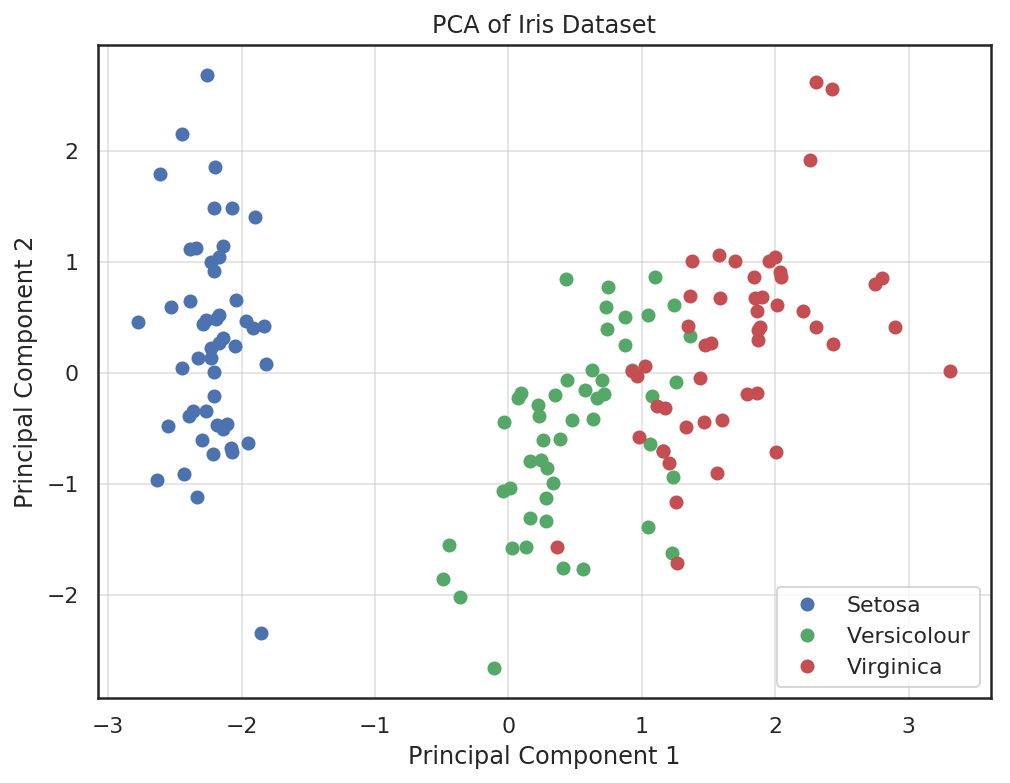

In [26]:
# Standardizing the data (mean centering and scaling to unit variance)
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Standardizing the features
scaler = StandardScaler()
X_standardized = scaler.fit_transform(X)

# Applying PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)

# Plotting the results of PCA
plt.figure(figsize=(8, 6))
plt.plot(X_pca[y == 0, 0], X_pca[y == 0, 1], 'bo', label='Setosa')
plt.plot(X_pca[y == 1, 0], X_pca[y == 1, 1], 'go', label='Versicolour')
plt.plot(X_pca[y == 2, 0], X_pca[y == 2, 1], 'ro', label='Virginica')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Iris Dataset')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()


In [27]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
import statsmodels.api as sm

# Train-test split and apply PCA (already done in your code)
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.3, stratify=y, random_state=42)

# Logistic Regression on PCA-transformed data
log_reg_pca = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=1000, random_state=42)
log_reg_pca.fit(X_train, y_train)

# Predictions
y_pred_pca = log_reg_pca.predict(X_test)

# Metrics
accuracy_pca = accuracy_score(y_test, y_pred_pca)
print(f'Accuracy on PCA-transformed data: {accuracy_pca:.5f}')
print("\nClassification Report (PCA-transformed data):")
print(classification_report(y_test, y_pred_pca, target_names=iris.target_names))

# Summary Table using Statsmodels
X_train_sm = sm.add_constant(X_train)  # Add intercept for statsmodels
logit_model_pca = sm.MNLogit(y_train, X_train_sm).fit()

# Display the summary table
summary_table_pca = logit_model_pca.summary2().tables[1]
import ace_tools as tools; tools.display_dataframe_to_user(name="Logistic Regression Summary Table (PCA)", dataframe=summary_table_pca)


Accuracy on PCA-transformed data: 0.88889

Classification Report (PCA-transformed data):
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.78      0.93      0.85        15
   virginica       0.92      0.73      0.81        15

    accuracy                           0.89        45
   macro avg       0.90      0.89      0.89        45
weighted avg       0.90      0.89      0.89        45

         Current function value: 0.128451
         Iterations: 35


/opt/conda/lib/python3.6/site-packages/statsmodels/base/model.py:512: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  "Check mle_retvals", ConvergenceWarning)


ModuleNotFoundError: No module named 'ace_tools'

The accuracy decreased slightly in this case (as actually some loss of information occured when we removed 2 dimensions), but, with other datasets with a high number of dimensions or features, PCA can drastically improve the accuracy of decision trees and other ensemble methods.

In [31]:
!pip install mlxtend --quiet


  ERROR: Could not find a version that satisfies the requirement pandas>=0.24.2 (from mlxtend) (from versions: none)
ERROR: No matching distribution found for pandas>=0.24.2 (from mlxtend)


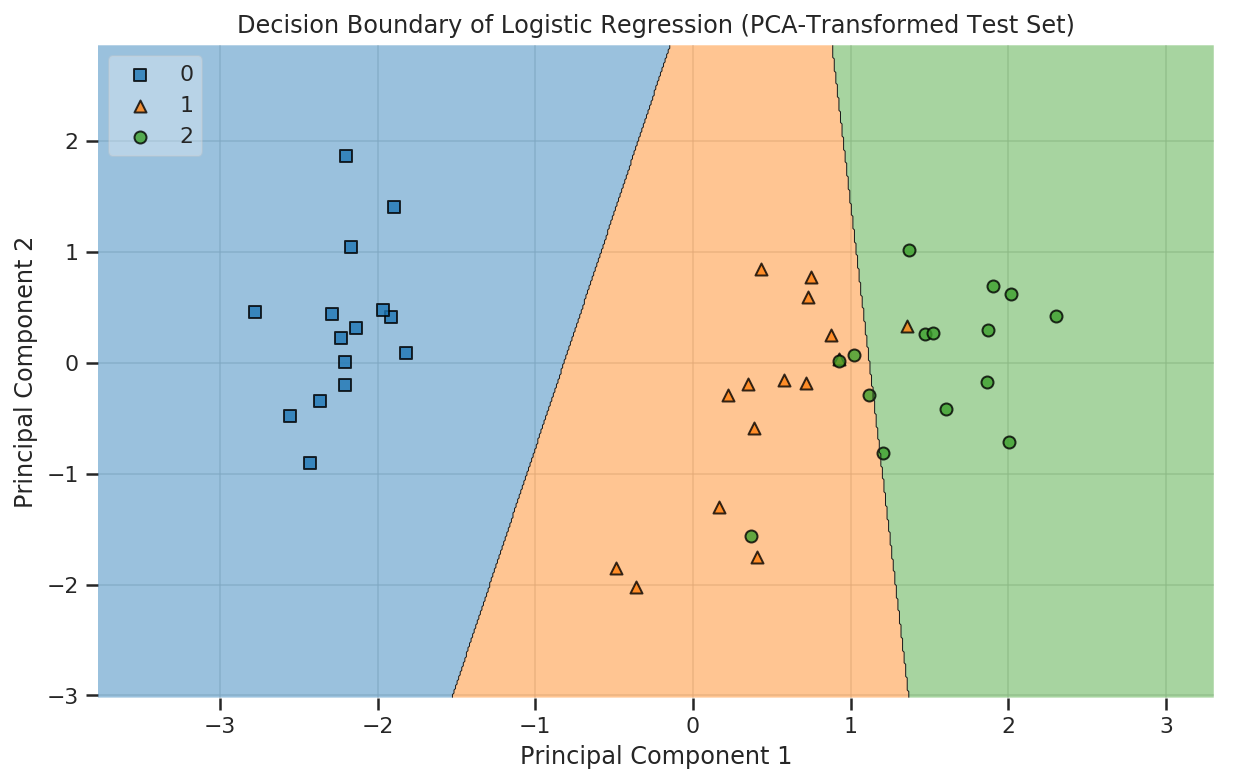

In [32]:
# Using an existing library for visualizing the decision boundary
from mlxtend.plotting import plot_decision_regions

# Combine test data and labels for compatibility with the library
X_test_combined = np.array(X_test)
y_test_combined = np.array(y_test)

# Plotting the decision boundary
plt.figure(figsize=(10, 6))
plot_decision_regions(X=X_test_combined, y=y_test_combined, clf=log_reg_pca, legend=2)

# Customizing the plot
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Decision Boundary of Logistic Regression (PCA-Transformed Test Set)')
plt.grid(alpha=0.5)
plt.show()


# Percentage of Variance Explained and The principal components in terms of the original variables

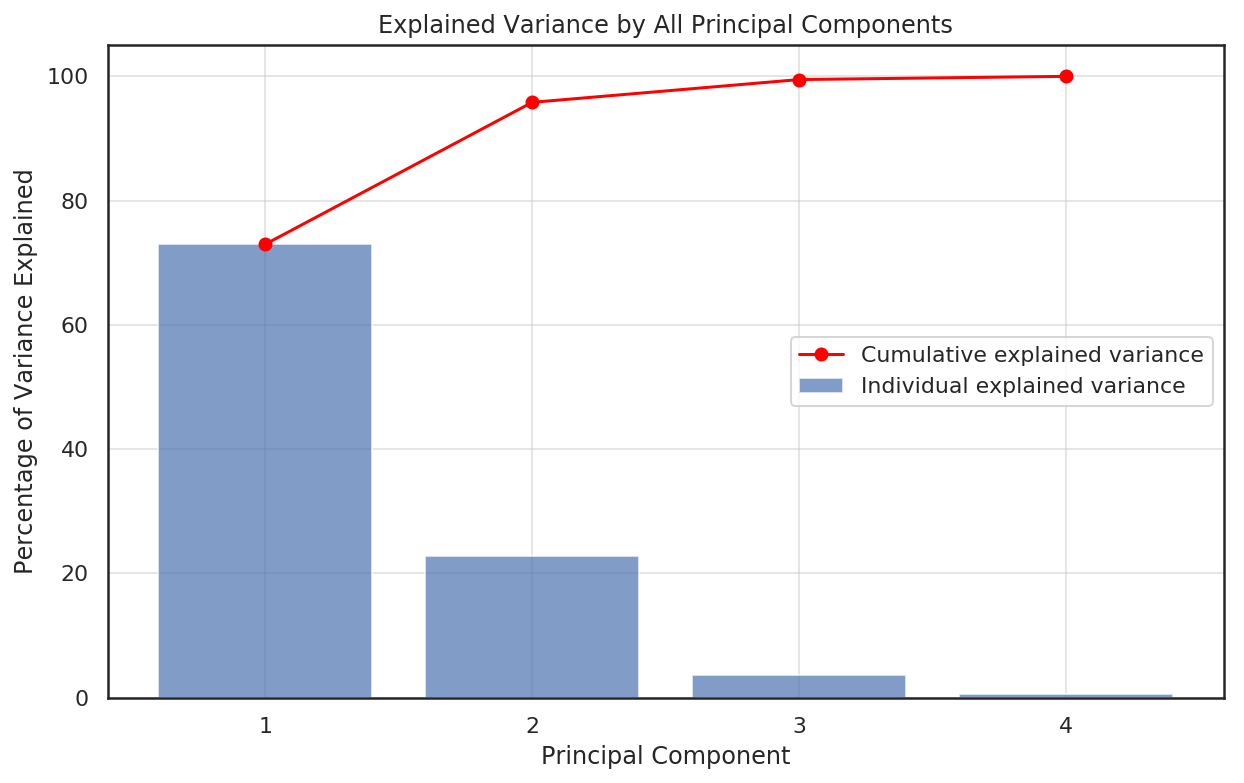

In [29]:
# Adjusting the plot to show variance explained by all 4 principal components

# Recompute PCA to include all 4 components
pca_all = PCA(n_components=4)
X_pca_all = pca_all.fit_transform(X_standardized)

# Cumulative explained variance
cumulative_variance_all = np.cumsum(pca_all.explained_variance_ratio_) * 100

# Individual explained variance
explained_variance_all = pca_all.explained_variance_ratio_ * 100

# Plotting
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(explained_variance_all) + 1), explained_variance_all, alpha=0.7, label='Individual explained variance')
plt.plot(range(1, len(cumulative_variance_all) + 1), cumulative_variance_all, marker='o', color='red', label='Cumulative explained variance')
plt.xticks(range(1, len(explained_variance_all) + 1))
plt.xlabel('Principal Component')
plt.ylabel('Percentage of Variance Explained')
plt.title('Explained Variance by All Principal Components')
plt.legend(loc='best')
plt.grid(alpha=0.5)
plt.show()


## We can clearly see first two principal components explain>90% of the total variance so our analysis by taking 2 principal components was acceptable

In [30]:
for i, component in enumerate(pca.components_):
    print("{} component: {}% of initial variance".format(i + 1, 
          round(100 * pca.explained_variance_ratio_[i], 2)))
    print(" + ".join("%.3f x %s" % (value, name)
                     for value, name in zip(component,
                                            iris.feature_names)))

1 component: 72.96% of initial variance
0.521 x sepal length (cm) + -0.269 x sepal width (cm) + 0.580 x petal length (cm) + 0.565 x petal width (cm)
2 component: 22.85% of initial variance
0.377 x sepal length (cm) + 0.923 x sepal width (cm) + 0.024 x petal length (cm) + 0.067 x petal width (cm)


# 2. Clustering

The main idea behind clustering is we have unlabelled points , and we can see that they may belong  into groups. Its our task to describe these things more concretely, and, when a new point comes in, assign it to the correct group." This general idea encourages exploration and opens up a variety of algorithms for clustering.

### K-means

K-means algorithm is the most popular and yet simplest of all the clustering algorithms. Here is how it works:
1. Select the number of clusters $k$ that you think is the optimal number.
2. Initialize $k$ points as "centroids" randomly within the space of our data.
3. Attribute each observation to its closest centroid.
4. Update the centroids to the center of all the attributed set of observations. 
5. Repeat steps 3 and 4 a fixed number of times or until all of the centroids are stable (i.e. no longer change in step 4).

This algorithm is easy to describe and visualize. Let's take a look.

# Data preparation of clustering
Here I would remove the labels so that the data set is ready for unsupervised task

In [34]:
# Preparing the dataset for clustering by removing labels
# Creating a dataset without labels (removing the target column)
df_without_labels = df.drop(columns=['target'])

# Standardizing the features (important for clustering)
scaler = StandardScaler()
X_standardized_clustering = scaler.fit_transform(df_without_labels)

# PCA to reduce dimensions (if needed for clustering visualization)
pca_clustering = PCA(n_components=2)  # Reduce to 2 components for easier visualization
X_pca_clustering = pca_clustering.fit_transform(X_standardized_clustering)

# Prepare DataFrames for clustering analysis
clustering_data = pd.DataFrame(X_pca_clustering, columns=['PC1', 'PC2'])

# Display the prepared data using standard pandas methods
# Prepared dataset for clustering
print("Prepared Dataset for Clustering:")
print(clustering_data.head())



Prepared Dataset for Clustering:
        PC1       PC2
0 -2.264703  0.480027
1 -2.080961 -0.674134
2 -2.364229 -0.341908
3 -2.299384 -0.597395
4 -2.389842  0.646835


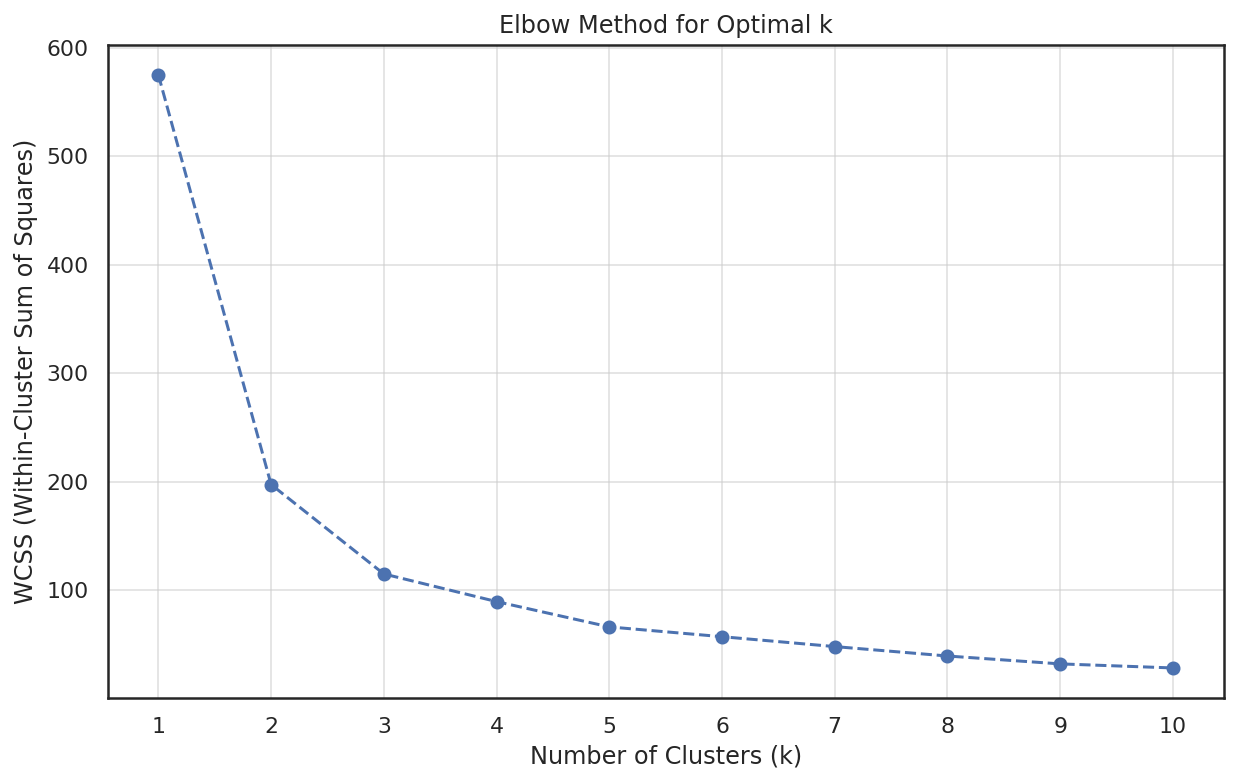

In [35]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

# Calculate WCSS (Within-Cluster Sum of Squares) for different values of k
wcss = []
k_values = range(1, 11)  # Testing k from 1 to 10
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(clustering_data)
    wcss.append(kmeans.inertia_)

# Plot the Elbow Graph
plt.figure(figsize=(10, 6))
plt.plot(k_values, wcss, marker='o', linestyle='--')
plt.title('Elbow Method for Optimal k')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.xticks(k_values)
plt.grid(alpha=0.5)
plt.show()


The elbow occurs at somewhere between k=2 & k=3 taking k=3 for the Kmeans algorithm later

# KMeans Clustering

In [37]:
# Perform KMeans with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
kmeans.fit(clustering_data)
labels = kmeans.labels_

# Add predicted labels to the dataset for visualization
clustering_data['Cluster'] = labels

# Plotting the KMeans clustered data for visualization

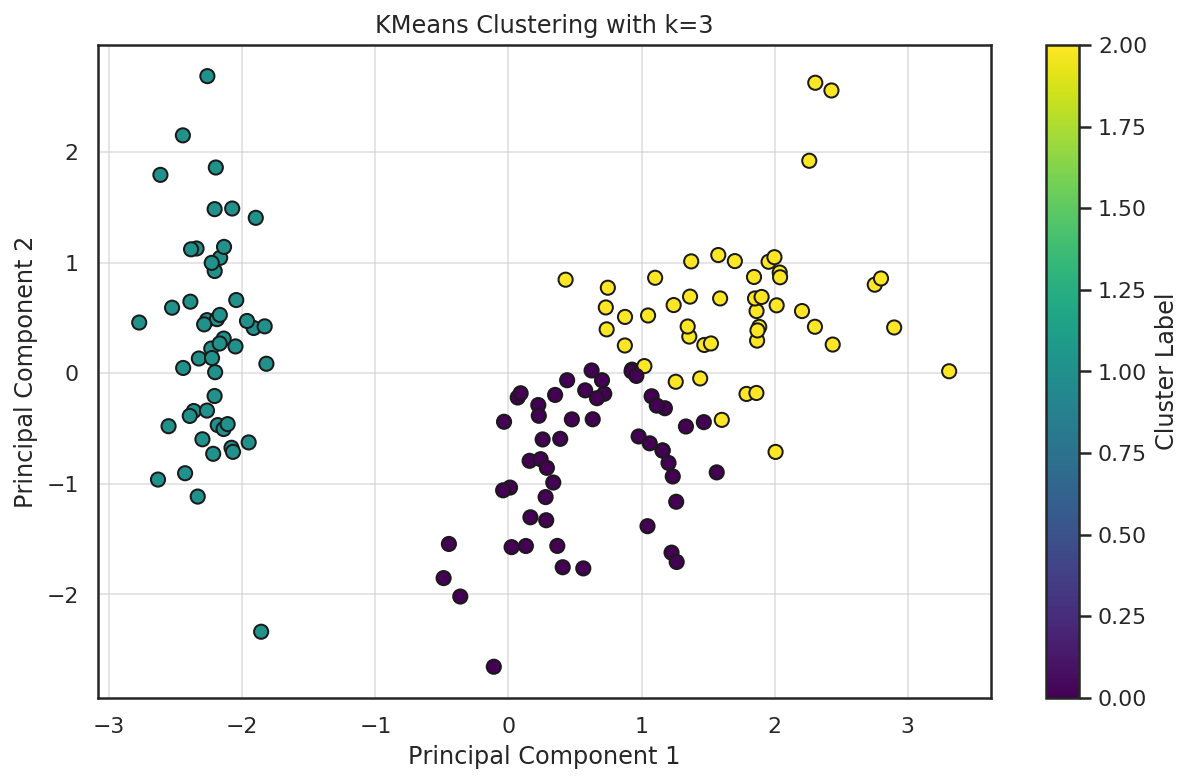

In [38]:
# Plot the dataset as per predicted labels
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data['PC1'], clustering_data['PC2'], c=labels, cmap='viridis', s=50, edgecolor='k')
plt.title('KMeans Clustering with k=3')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(alpha=0.5)
plt.show()

# Agglomerative clustering


The following algorithm is the simplest and easiest to understand among all the the clustering algorithms without a fixed number of clusters.


The algorithm is :
1. We start by assigning each observation to its own cluster
2. Then sort the pairwise distances between the centers of clusters in descending order
3. Take the nearest two neigbor clusters and merge them together, and recompute the centers
4. Repeat steps 2 and 3 until all the data is merged into one cluster

The process of searching for the nearest cluster can be conducted with different methods of bounding the observations:
1. Single linkage 
2. Complete linkage 
3. Average linkage 
4. Centroid linkage 


The results can be visualized as a cluster tree (dendogram) to help recognize the moment the algorithm should be stopped to get optimal results.

## Dendogram

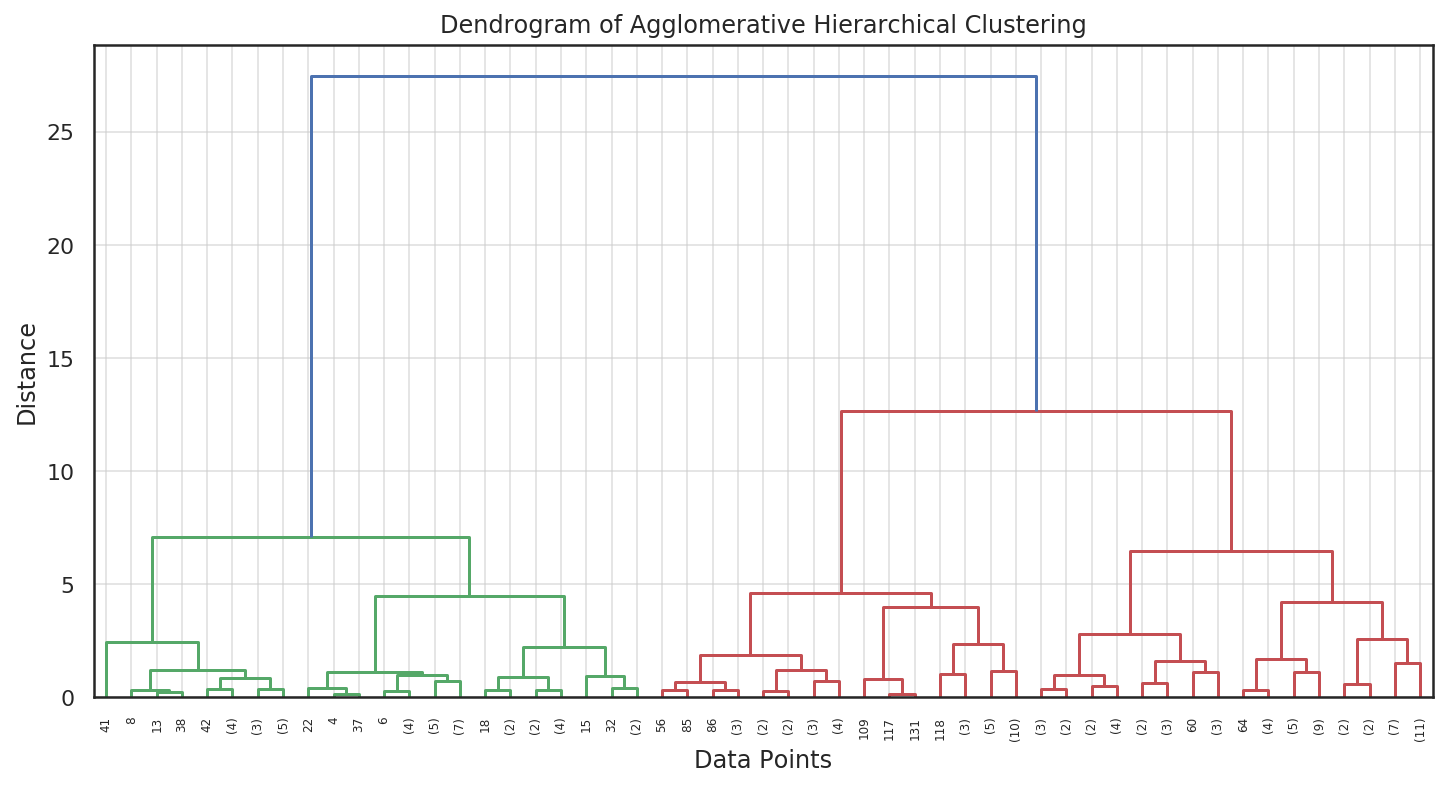

In [39]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Perform hierarchical clustering and compute linkage matrix
linkage_matrix = linkage(clustering_data[['PC1', 'PC2']], method='ward')

# Plot the dendrogram
plt.figure(figsize=(12, 6))
dendrogram(linkage_matrix, truncate_mode='level', p=5, color_threshold=0.7 * max(linkage_matrix[:, 2]))
plt.title('Dendrogram of Agglomerative Hierarchical Clustering')
plt.xlabel('Data Points')
plt.ylabel('Distance')
plt.grid(alpha=0.5)
plt.show()


By looking at the dendogram the longest line undivided is between 12 to 26 so if I put a cut there we will get 2 clusters so now I will perform agglomerative clustering with k=2 clusters.

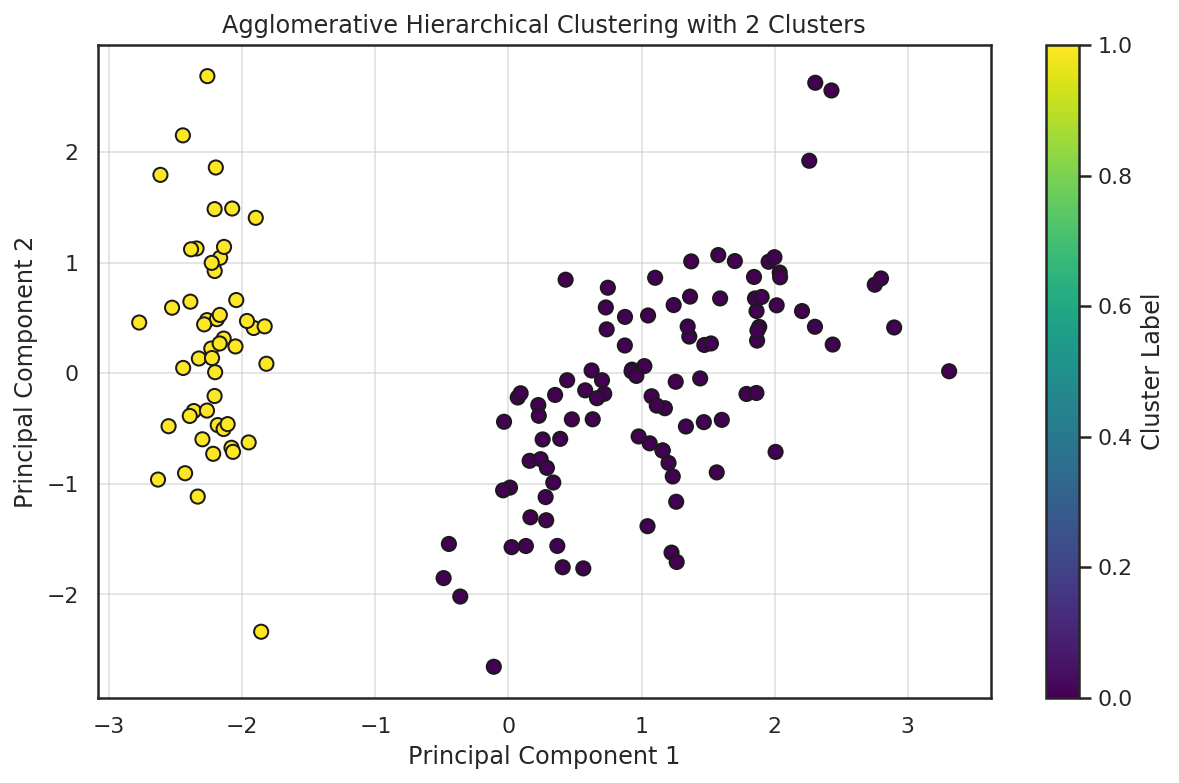

In [41]:
from sklearn.cluster import AgglomerativeClustering

# Perform Agglomerative Hierarchical Clustering with 2 clusters
hierarchical_clustering_2 = AgglomerativeClustering(n_clusters=2, linkage='ward')
labels_hierarchical_2 = hierarchical_clustering_2.fit_predict(clustering_data[['PC1', 'PC2']])

# Add predicted labels to the dataset for visualization
clustering_data['Hierarchical Cluster (2 Clusters)'] = labels_hierarchical_2

# Plot the dataset as per predicted labels by hierarchical clustering (2 clusters)
plt.figure(figsize=(10, 6))
plt.scatter(clustering_data['PC1'], clustering_data['PC2'], c=labels_hierarchical_2, cmap='viridis', s=50, edgecolor='k')
plt.title('Agglomerative Hierarchical Clustering with 2 Clusters')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar(label='Cluster Label')
plt.grid(alpha=0.5)
plt.show()
